In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import cross_val_score

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# Create dummy variables

In [2]:
df = pd.read_csv('model.csv', index_col=0)

In [4]:
df.head()

,price,proc_cores,proc_speed,mem_type,mem_cap,num_USB,storage_type,storage_cap,graphics,form,brand
0,930,6.0,3.2,ddr4,16.0,8.0,hdd,2048.0,NVIDIA,TOWER,LENOVO
1,1050,6.0,3.2,ddr4,16.0,8.0,hdd,2048.0,NVIDIA,TOWER,LENOVO
2,379,2.0,3.6,ddr4,4.0,8.0,hdd,1024.0,INTEGRATED,TOWER,LENOVO
3,674,4.0,3.1,ddr4,8.0,8.0,ssd,256.0,INTEGRATED,SMALL,DELL
5,823,6.0,3.1,ddr4,16.0,3.0,hdd,1024.0,INTEGRATED,SMALL,DELL


In [5]:
df.reset_index(inplace=True, drop=True)

In [6]:
df.columns.values

array(['price', 'proc_cores', 'proc_speed', 'mem_type', 'mem_cap',
       'num_USB', 'storage_type', 'storage_cap', 'graphics', 'form',
       'brand'], dtype=object)

In [7]:
ram = pd.get_dummies(df['mem_type'])

In [8]:
disk = pd.get_dummies(df['storage_type'])

In [9]:
graph = pd.get_dummies(df['graphics'])

In [10]:
case = pd.get_dummies(df['form'])

In [11]:
br = pd.get_dummies(df['brand'])

In [12]:
df.drop(labels=['mem_type', 'storage_type', 'graphics', 'form', 'brand'], inplace=True, axis=1)

In [13]:
categoricals = pd.concat([ram, disk, graph, case, br], sort=True, axis=1)

In [14]:
df = df.join(categoricals)

In [15]:
df.columns = df.columns.str.lower()

In [16]:
df_viz = df[['price', 'proc_cores', 'proc_speed', 'mem_cap', 'num_usb', 'storage_cap']]

In [18]:
df.to_csv('')

,price,proc_cores,proc_speed,mem_cap,num_usb,storage_cap,ddr2,ddr3,ddr4,hdd,ssd,amd,integrated,nvidia,small,tower,dell,hp,lenovo
0,930,6.0,3.2,16.0,8.0,2048.0,0,0,1,1,0,0,0,1,0,1,0,0,1
1,1050,6.0,3.2,16.0,8.0,2048.0,0,0,1,1,0,0,0,1,0,1,0,0,1
2,379,2.0,3.6,4.0,8.0,1024.0,0,0,1,1,0,0,1,0,0,1,0,0,1
3,674,4.0,3.1,8.0,8.0,256.0,0,0,1,0,1,0,1,0,1,0,1,0,0
4,823,6.0,3.1,16.0,3.0,1024.0,0,0,1,1,0,0,1,0,1,0,1,0,0


## Visualisations

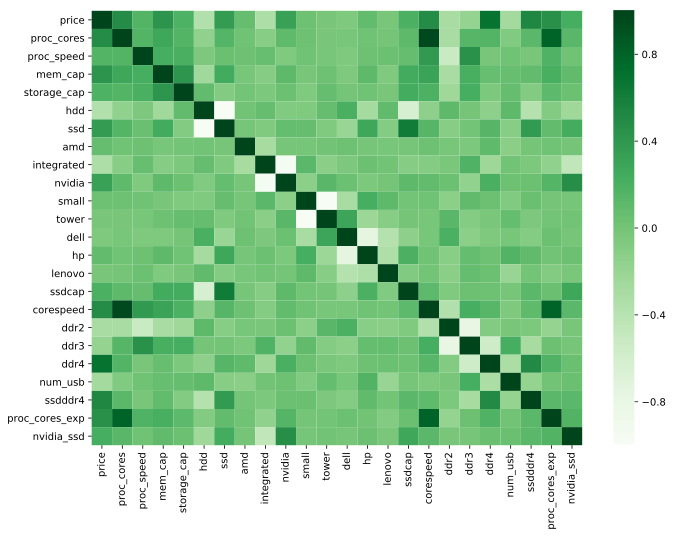

In [803]:
plt.figure(figsize=(11, 8))
sns.heatmap(df_manip.corr(), cmap='Greens');

In [847]:
from scipy import stats

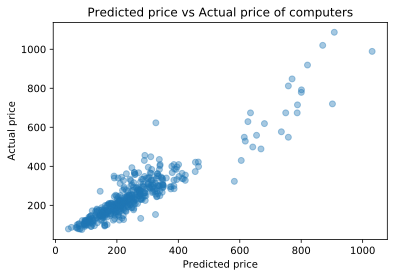

In [73]:
plt.scatter(y_pred, y_test, alpha=0.4)
plt.title('Predicted price vs Actual price of computers')
plt.xlabel('Predicted price')
plt.ylabel('Actual price');

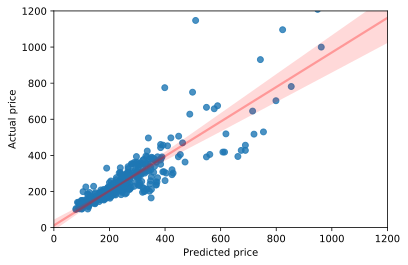

In [906]:
sns.regplot(y_test, y_pred, line_kws={'color': 'r', 'alpha': 0.3})
plt.xlim([0, 1200])
plt.ylim([0, 1200])
plt.xlabel('Predicted price')
plt.ylabel('Actual price');

In [907]:
res = y_pred - y_test

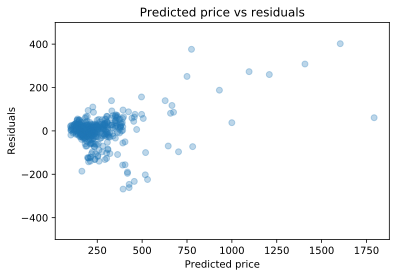

In [908]:
plt.scatter(y_pred, res, alpha=0.3)
plt.xlabel('Predicted price')
plt.ylabel('Residuals')
plt.ylim([-500, 500])
plt.title('Predicted price vs residuals');

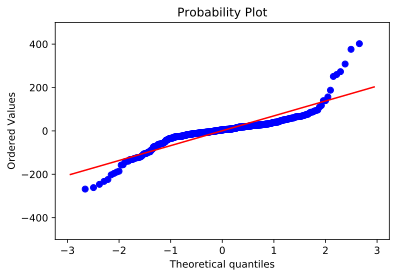

In [909]:
stats.probplot(res, dist='norm', plot=plt)
plt.ylim([-500, 500]);

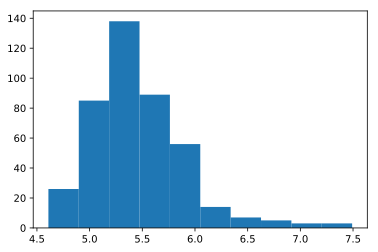

In [911]:
plt.hist(np.log(y_pred));

## Start modeling

In [872]:
df_manip.columns.values

array(['price', 'proc_cores', 'proc_speed', 'mem_cap', 'storage_cap',
       'hdd', 'ssd', 'amd', 'integrated', 'nvidia', 'small', 'tower',
       'dell', 'hp', 'lenovo', 'ssdcap', 'corespeed', 'ddr2', 'ddr3',
       'ddr4', 'num_usb', 'ssdddr4', 'nvidia_ssd'], dtype=object)

In [873]:
df_manip.drop(labels=['hdd', 'amd', 'small', 'dell', 'ddr2', 'ddr3'], inplace=True, axis=1)

In [801]:
df_manip['nvidia_ssd'] = df_manip['nvidia']*df_manip['ssd']

In [837]:
df_manip.head()

,price,proc_cores,proc_speed,mem_cap,storage_cap,hdd,ssd,amd,integrated,nvidia,...,hp,lenovo,ssdcap,corespeed,ddr2,ddr3,ddr4,num_usb,ssdddr4,nvidia_ssd
0,930,6.0,3.2,16.0,2048.0,1,0,0,0,1,...,0,1,0.0,19.2,0,0,1,8.0,0,0
1,1050,6.0,3.2,16.0,2048.0,1,0,0,0,1,...,0,1,0.0,19.2,0,0,1,8.0,0,0
2,379,2.0,3.6,4.0,1024.0,1,0,0,1,0,...,0,1,0.0,7.2,0,0,1,8.0,0,0
3,674,4.0,3.1,8.0,256.0,0,1,0,1,0,...,0,0,256.0,12.4,0,0,1,8.0,1,0
4,823,6.0,3.1,16.0,1024.0,1,0,0,1,0,...,0,0,0.0,18.6,0,0,1,3.0,0,0


In [778]:
df_manip['proc_cores_exp'] = np.exp(df_manip['proc_cores'])

In [804]:
df_manip.head()

,price,proc_cores,proc_speed,mem_cap,storage_cap,hdd,ssd,amd,integrated,nvidia,...,lenovo,ssdcap,corespeed,ddr2,ddr3,ddr4,num_usb,ssdddr4,proc_cores_exp,nvidia_ssd
0,930,6.0,3.2,16.0,2048.0,1,0,0,0,1,...,1,0.0,19.2,0,0,1,8.0,0,403.428793,0
1,1050,6.0,3.2,16.0,2048.0,1,0,0,0,1,...,1,0.0,19.2,0,0,1,8.0,0,403.428793,0
2,379,2.0,3.6,4.0,1024.0,1,0,0,1,0,...,1,0.0,7.2,0,0,1,8.0,0,7.389056,0
3,674,4.0,3.1,8.0,256.0,0,1,0,1,0,...,0,256.0,12.4,0,0,1,8.0,1,54.598150,0
4,823,6.0,3.1,16.0,1024.0,1,0,0,1,0,...,0,0.0,18.6,0,0,1,3.0,0,403.428793,0


In [301]:
df['ssdcap'] = df['ssd']*df['storage_cap']

In [402]:
df['corespeed'] = df['proc_cores']*df['proc_speed']

In [631]:
df['ssdddr4'] = df['ssd']*df['ddr4']

In [467]:
df_manip = df.copy()

In [468]:
df_manip.columns.values

array(['price', 'proc_cores', 'proc_speed', 'mem_cap', 'num_usb',
       'storage_cap', 'ddr2', 'ddr3', 'ddr4', 'hdd', 'ssd', 'amd',
       'integrated', 'nvidia', 'small', 'tower', 'dell', 'hp', 'lenovo',
       'ssdcap', 'corespeed'], dtype=object)

In [534]:
df_manip.drop(labels=['num_usb'], inplace=True, axis=1)

In [632]:
df_manip['ssdddr4'] = df_manip['ssd']*df_manip['ddr4']

In [519]:
df_manip.columns.values

array(['price', 'proc_cores', 'proc_speed', 'mem_cap', 'storage_cap',
       'hdd', 'ssd', 'amd', 'integrated', 'nvidia', 'small', 'tower',
       'dell', 'hp', 'lenovo', 'ssdcap', 'corespeed'], dtype=object)

In [694]:
df_manip.to_csv('df_manip.csv')

In [516]:
df.columns.values

array(['price', 'proc_cores', 'proc_speed', 'mem_cap', 'num_usb',
       'storage_cap', 'ddr2', 'ddr3', 'ddr4', 'hdd', 'ssd', 'amd',
       'integrated', 'nvidia', 'small', 'tower', 'dell', 'hp', 'lenovo',
       'ssdcap', 'corespeed'], dtype=object)

In [426]:
y = df['price']

In [427]:
X = df.iloc[:, 1:]

In [721]:
def tts(df, d=1):
    y = df['price']
    X = df.iloc[:, 1:]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    mod = LinearRegression()
    
    pipe = make_pipeline(PolynomialFeatures(d, interaction_only=True), StandardScaler(), mod)

    fit = pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    print(f'R^2: {fit.score(X_test, y_test)}')
    print(f'MSE: {mean_squared_error(y_pred, y_test)}')

In [725]:
tts(df_manip, d=1)

R^2: 0.7991868193739113
MSE: 6437.587405790654


In [903]:
def cross_val(df, degree):
    X = df.iloc[:, 1:]
    y = df['price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, np.log(y))
    
    reg = LinearRegression()

    pipe = make_pipeline(PolynomialFeatures(degree, interaction_only=True), StandardScaler(), reg)
    
    fit = pipe.fit(X_train, y_train)

    scores = cross_val_score(pipe, X_train, y_train, cv=10, scoring='r2')
    mse_scores = cross_val_score(pipe, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    
    print(f'Cross validated R^2: {np.mean(scores)}')
    print(f'Cross validated MSE: {-1*np.mean(mse_scores)}')
    print(f'RMSE: {np.sqrt(-1*np.mean(mse_scores))}')
    
    y_pred = pipe.predict(X_test)
    
    print(f'Prediction MSE: {mean_squared_error(y_pred, y_test)}')
    print(f'Prediction score: {fit.score(X_test, y_test)}')
    
    return np.exp(y_pred), np.exp(y_test)

In [904]:
y_pred, y_test = cross_val(df_manip, degree=1)

Cross validated R^2: 0.7650634112082156
Cross validated MSE: 0.05526590459009578
RMSE: 0.23508701493297282
Prediction MSE: 0.04034446663164534
Prediction score: 0.8284581932984606


In [905]:
y_test

1203    455.0
953     147.0
798     212.0
167     367.0
1618    206.0
78      608.0
252     962.0
1306    225.0
291     323.0
430     302.0
866     192.0
1693    206.0
485     243.0
807     183.0
1059    121.0
1608    359.0
1272    167.0
595     281.0
263     499.0
1420    340.0
1675    183.0
304     121.0
341     386.0
1204     96.0
1125    299.0
1462    131.0
655     346.0
1122    242.0
90      384.0
1256    241.0
        ...  
131     689.0
978     149.0
1312    101.0
1078    131.0
1050    185.0
1214    189.0
152     392.0
954     167.0
1667    350.0
1152    230.0
104     409.0
681     259.0
139     249.0
896     280.0
31      143.0
89      332.0
955     619.0
1173    218.0
1642    344.0
959     210.0
1023    152.0
262     489.0
637     194.0
255     351.0
1021    211.0
812     148.0
1244    336.0
668     278.0
1521    116.0
1596    179.0
Name: price, Length: 426, dtype: float64

## Regularization

In [375]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [620]:
def regularization(df, degree, model=Ridge):
    fig, axes = plt.subplots(2, 1, figsize=(7, 10))
    
    X = df.iloc[:, 1:]
    y = df['price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    mse_train = []
    mse_test = []

    r2_train = []
    r2_test = []

    alphas = [1e-14, 1e-6, 1e-2, .01, 1, 10, 100, 1000]

    for a in alphas:
        scaled_mod = make_pipeline(PolynomialFeatures(degree, interaction_only=True), StandardScaler(),
                                   model(alpha=a, max_iter=10000))
        scaled_mod.fit(X_train, y_train)

        mse_train.append(mean_squared_error(y_train, scaled_mod.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, scaled_mod.predict(X_test)))

        r2_train.append(scaled_mod.score(X_train, y_train))
        r2_test.append(scaled_mod.score(X_test, y_test))
        
    axes[0].semilogx(alphas, mse_train,label='train',c='r')
    axes[0].semilogx(alphas, mse_test,label='test',c='b')
    axes[0].legend()
    axes[0].set_xlabel('Alpha')
    axes[0].set_ylabel('MSE')
    axes[0].set_ylim([0, 12000])
    
    axes[1].semilogx(alphas,r2_train,label='train',c='r')
    axes[1].semilogx(alphas,r2_test,label='test',c='b')
    axes[1].set_ylim(0,1)
    axes[1].legend()
    axes[1].set_xlabel('Alpha')
    axes[1].set_ylabel('Rˆ2');

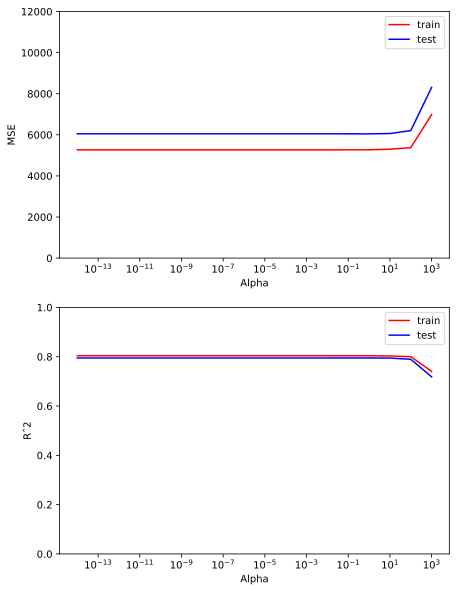

In [651]:
regularization(df_manip, degree=1, model=Ridge)

In [675]:
def regularizationCV(df, model=RidgeCV):
    fig, axes = plt.subplots(2, 1, figsize=(7, 10))
    
    X = df.iloc[:, 1:]
    y = df['price']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    alphas = [1e-14, 1e-6, 1e-2, .01, 1, 100, 1000]

    
    
    mse_train = []
    mse_test = []
    
    r2_train = []
    r2_test = []
    
    for d in range(1, 4):
        scaled_mod = make_pipeline(PolynomialFeatures(d, interaction_only=True), StandardScaler(),
                                   model(alphas=alphas, cv=10))
        scaled_mod.fit(X_train, y_train)

        mse_train.append(mean_squared_error(y_train, scaled_mod.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, scaled_mod.predict(X_test)))

        r2_train.append(scaled_mod.score(X_train, y_train))
        r2_test.append(scaled_mod.score(X_test, y_test))
        
    axes[0].plot(range(1, 4), mse_train, label='train',c='r')
    axes[0].plot(range(1, 4), mse_test, label='test',c='b')
    axes[0].legend()
    axes[0].set_xlabel('Polynomial Degree')
    axes[0].set_ylabel('MSE')
    axes[0].set_ylim([0, 12000])
    
    axes[1].plot(range(1, 4), r2_train, label='train',c='r')
    axes[1].plot(range(1, 4), r2_test, label='test',c='b')
    axes[1].set_ylim(0,1)
    axes[1].legend()
    axes[1].set_xlabel('Polynomial Degree')
    axes[1].set_ylabel('Rˆ2');

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.920665e-18
  overwrite_a=True).T
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/

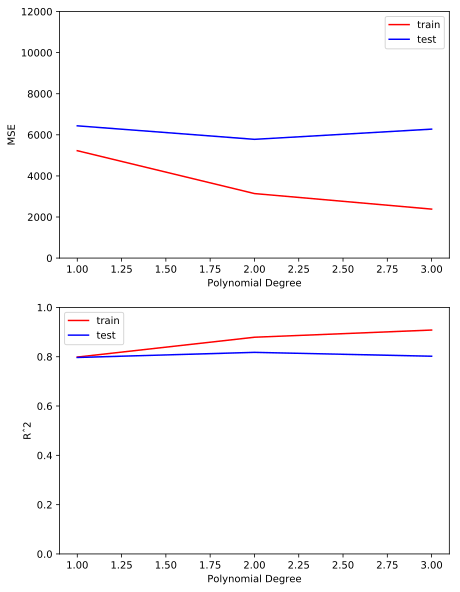

In [676]:
regularizationCV(df_manip, model=RidgeCV)

## Recursive feature elimination

In [315]:
from sklearn.feature_selection import RFECV 

def feature_reduction(X, y, deg=1):
    # Get best features of model using RFECV and make a new prediction using best features
    reg = LinearRegression() 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    reg.fit(X_train, y_train)
    
    mse_train = mean_squared_error(y_train, reg.predict(X_train))
    mse_test = mean_squared_error(y_test, reg.predict(X_test))
    
    r2_train = reg.score(X_train, y_train)
    r2_test = reg.score(X_test, y_test)
    
    # Check out MSE and R2 of train/test before we do feature reduction
    print('BEFORE FEATURE REDUCTION')
    print(f'Training MSE: {mse_train}\nTesting MSE: {mse_test}\nTraining R2: {r2_train}\nTesting R2: {r2_test}\n')

    # Make RFECV model and fit it
    rfecv = RFECV(estimator=reg, step=1, cv=10, scoring='r2')
    rfecv.fit(X_train, y_train)
    
    
    # Grab only the "best" Xs
    X_new = rfecv.transform(X)
    
    print(f'Reduced features shape: {X_new.shape}\n')
    
    # train test split using our new set of X's
    Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_new, y, test_size=0.3)
    
    pipe = make_pipeline(PolynomialFeatures(deg, interaction_only=True), StandardScaler(), LinearRegression())
    pipe.fit(Xn_train, yn_train)
    
    msen_train = mean_squared_error(yn_train, pipe.predict(Xn_train))
    msen_test = mean_squared_error(yn_test, pipe.predict(Xn_test))
    
    r2n_train = pipe.score(Xn_train, yn_train)
    r2n_test = pipe.score(Xn_test, yn_test)
    
    print('AFTER FEATURE REDUCTION')
    print(f'Training MSE: {msen_train}\nTesting MSE: {msen_test}\nTraining R2: {r2n_train}\nTesting R2: {r2n_test}')
    
    
    sns.regplot(pipe.predict(Xn_test), yn_test, ci=95, line_kws={'color': 'r'}, scatter_kws={'alpha': 0.4})
    plt.legend(('Line of best fit', 'Data'))
    plt.xlim([0, 1500])
    plt.ylim([0, 1500])
    plt.ylabel('Actual price')
    plt.xlabel('Predicted price');
    

BEFORE FEATURE REDUCTION
Training MSE: 6837.071843783757
Testing MSE: 4370.509177456517
Training R2: 0.7708354148771094
Testing R2: 0.806943190513419

Reduced features shape: (1703, 19)

AFTER FEATURE REDUCTION
Training MSE: 6388.545281680925
Testing MSE: 5431.907906508531
Training R2: 0.7822180118082087
Testing R2: 0.772051653080743


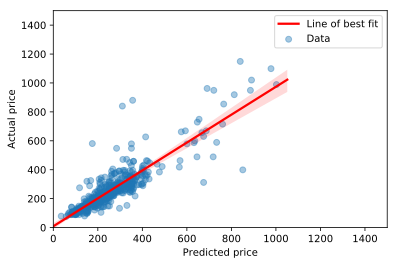

In [316]:
feature_reduction(X, y, deg=1)

In [262]:
score

0.7875677223751015

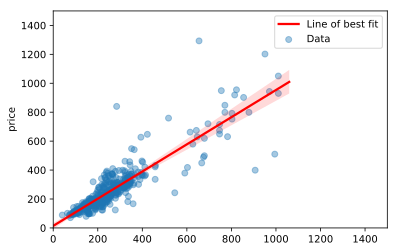

In [263]:
sns.regplot(y_pred, y_test, ci=95, line_kws={'color': 'r'}, scatter_kws={'alpha': 0.4})
plt.legend(('Line of best fit', 'Data'))
plt.xlim([0, 1500])
plt.ylim([0, 1500]);